In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

if not os.path.exists('Machine-Learning-Assignment'):
    print("Cloning GitHub Repository...")
    !git clone https://github.com/mostafa-cse/Machine-Learning-Assignment.git
else:
    print("Repository already exists. Pulling latest changes...")
    !cd Machine-Learning-Assignment && git pull

REPO_PATH = './Machine-Learning-Assignment/CNN_Implementation'
TRAIN_DIR = os.path.join(REPO_PATH, 'train_dataset','train')
CUSTOM_TEST_DIR = os.path.join(REPO_PATH, 'custom_dataset')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

Repository already exists. Pulling latest changes...
Already up to date.

Checking paths:
Train Data Path: ./Machine-Learning-Assignment/CNN_Implementation/train_dataset/train -> Exists? True
Custom Data Path: ./Machine-Learning-Assignment/CNN_Implementation/custom_dataset -> Exists? True

Using device: cpu


In [72]:
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
LEARNING_RATE = 0.001
EPOCHS = 10

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    full_dataset = ImageFolder(root=TRAIN_DIR, transform=transform)
    class_names = full_dataset.classes
    print(f"Classes found: {class_names}")

    # Split into Train (80%) and Validation (20%)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Total Images: {len(full_dataset)}")
    print(f"Training Set: {len(train_dataset)} images")
    print(f"Validation Set: {len(val_dataset)} images")

except Exception as e:
    print(f"Error loading dataset: {e}")

Classes found: ['paper', 'rock', 'scissors']
Total Images: 6896
Training Set: 5516 images
Validation Set: 1380 images


In [73]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize Model korsi
model = CNN(num_classes=len(class_names)).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # ---  Model Train korsi
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    # --- Validation check kora
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")

print("Training Complete!!")

# save Model
model_save_name = '200108.pth'
torch.save(model.state_dict(), model_save_name)
print(f"Model saved locally as {model_save_name}")

Starting Training...
Epoch [1/10] | Train Acc: 83.09% | Val Acc: 97.68% | Val Loss: 0.0819
Epoch [2/10] | Train Acc: 98.17% | Val Acc: 99.35% | Val Loss: 0.0224
Epoch [3/10] | Train Acc: 98.88% | Val Acc: 99.78% | Val Loss: 0.0155
Epoch [4/10] | Train Acc: 99.58% | Val Acc: 99.78% | Val Loss: 0.0114
Epoch [5/10] | Train Acc: 99.82% | Val Acc: 99.13% | Val Loss: 0.0247
Epoch [6/10] | Train Acc: 98.97% | Val Acc: 99.35% | Val Loss: 0.0264
Epoch [7/10] | Train Acc: 99.55% | Val Acc: 99.71% | Val Loss: 0.0145
Epoch [8/10] | Train Acc: 99.69% | Val Acc: 99.78% | Val Loss: 0.0040
Epoch [9/10] | Train Acc: 99.87% | Val Acc: 99.86% | Val Loss: 0.0052
Epoch [10/10] | Train Acc: 99.89% | Val Acc: 99.78% | Val Loss: 0.0020
Training Complete.
Model saved locally as 200108.pth


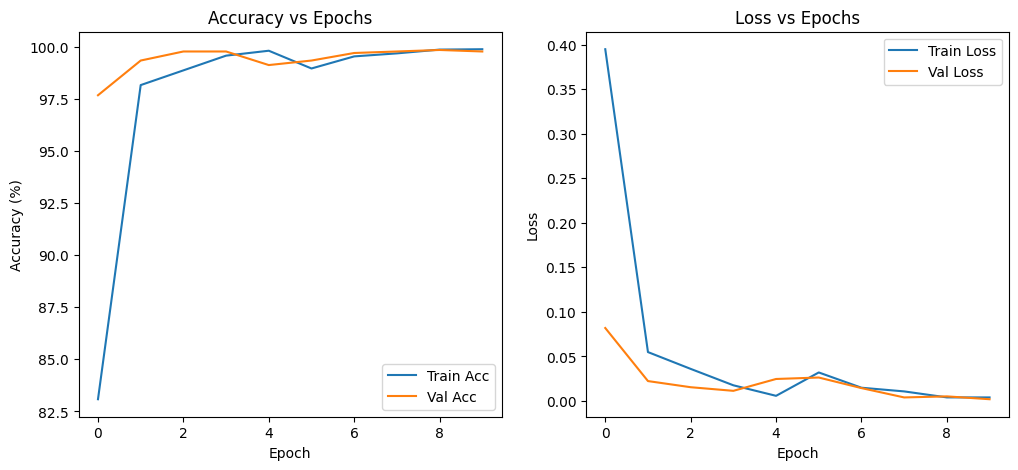

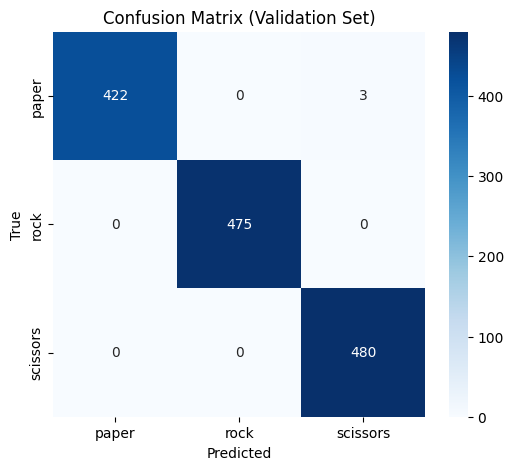

Visual Error Analysis (Displaying 3 mistakes):


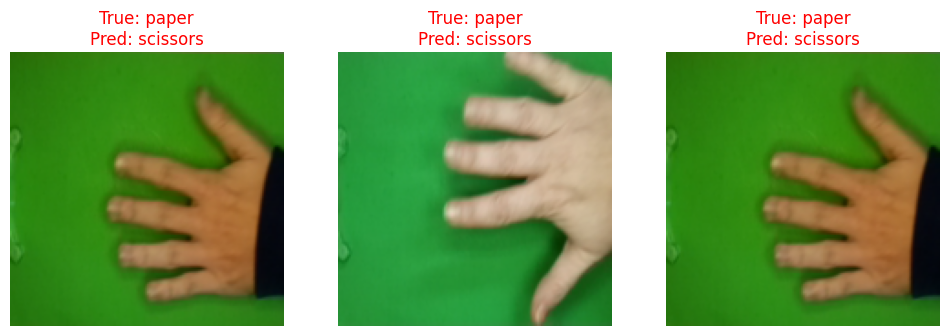

In [75]:
# 1. Training History Plots
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Confusion Matrix & Error Analysis
all_preds = []
all_labels = []
mistakes = [] # To store images classified incorrectly

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store for Confusion Matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store mistakes for visualization
        # We only check the first batch or so to save memory
        if len(mistakes) < 3:
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    mistakes.append((images[i].cpu(), labels[i].item(), predicted[i].item()))

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

# 3. Visual Error Analysis
if mistakes:
    print(f"Visual Error Analysis (Displaying {len(mistakes)} mistakes):")
    plt.figure(figsize=(12, 4))
    for i, (img, true_idx, pred_idx) in enumerate(mistakes[:3]):
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5 # Un-normalize
        plt.subplot(1, 3, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}", color='red')
        plt.axis('off')
    plt.show()
else:
    print("Excellent! No errors found in the checked validation samples.")

Found 11 custom images.


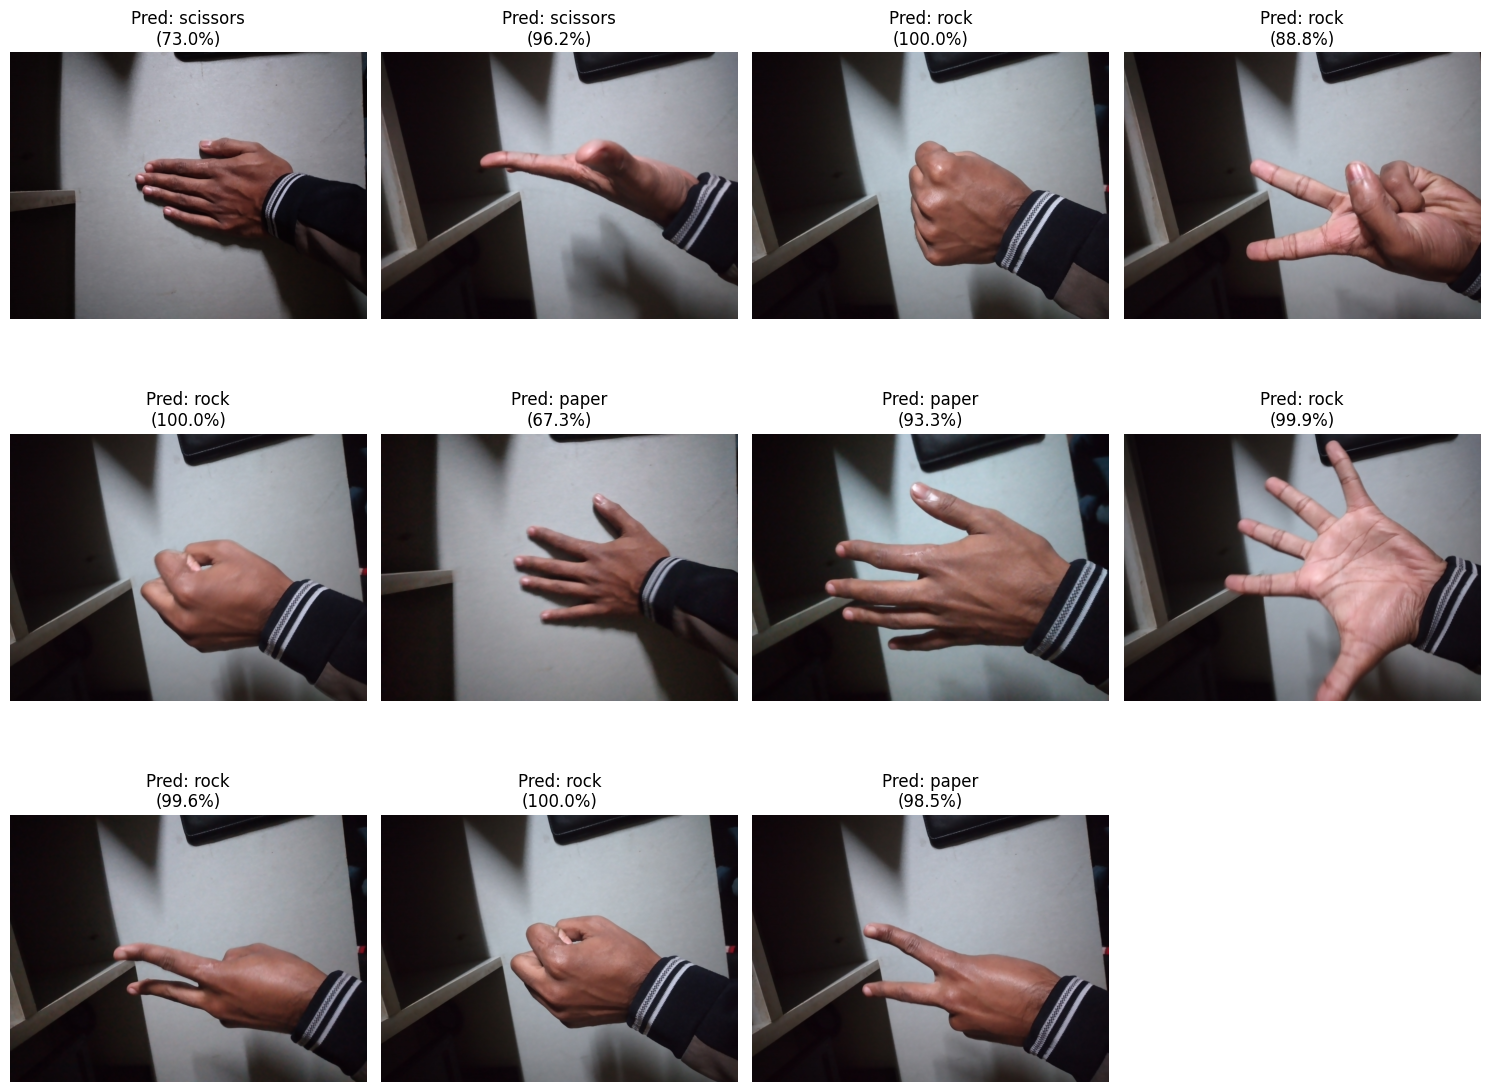

In [76]:
def predict_image(image_path, model):
    try:
        # Load and Transform
        image = Image.open(image_path).convert('RGB')
        # Apply same transform as training
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        return class_names[predicted.item()], confidence.item() * 100, image
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None, None, None

# Gather images from the custom folder
custom_images = [f for f in os.listdir(CUSTOM_TEST_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Found {len(custom_images)} custom images.")

if custom_images:
    # Setup Grid Plot
    cols = 4
    rows = (len(custom_images) // cols) + 1
    plt.figure(figsize=(15, 4 * rows))

    for i, img_file in enumerate(custom_images):
        img_path = os.path.join(CUSTOM_TEST_DIR, img_file)
        pred_class, conf, original_img = predict_image(img_path, model)

        if original_img:
            plt.subplot(rows, cols, i+1)
            plt.imshow(original_img)
            plt.title(f"Pred: {pred_class}\n({conf:.1f}%)")
            plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images found in 'custom_dataset'. Please check your GitHub repo.")